<a href="https://colab.research.google.com/github/samyumobi/30DaysofPython/blob/main/calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NameError: name 'calibration' is not defined

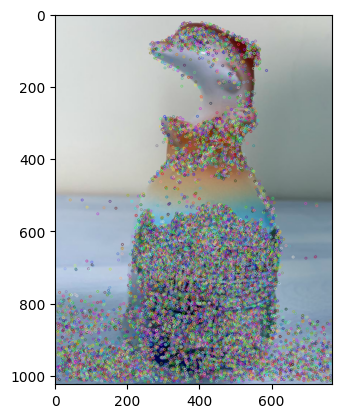

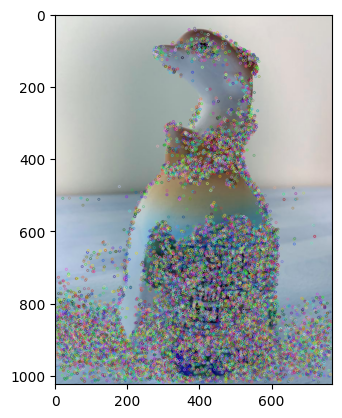

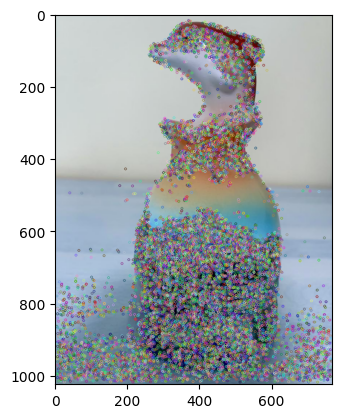

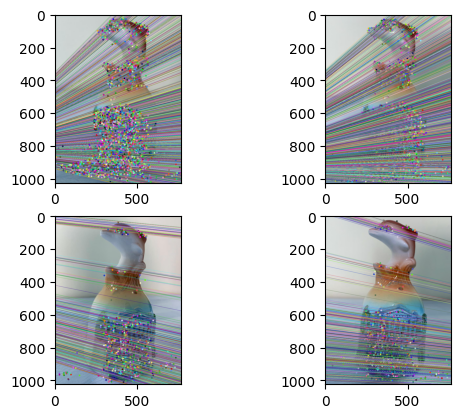

In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
# import calibration
from scipy import optimize

import scipy

imgL = cv.imread("imgL.jpeg")  # queryimage # left image
imgM = cv.imread("imgM.jpeg")  # trainimage # middle image
imgR = cv.imread('imgR.jpeg')  # trainimage # right image
imgMR = cv.imread('imgM.jpeg') # Copy of middle image to later reconstruct the object with using 3 images.
imgML = cv.imread('imgM.jpeg') # Copy of middle image to later reconstruct the object with using 3 images.

"""Explanation: L = Left, M = Middle, R = Right
    ML = Middle-Left, MR = Middle-Right"""

sift = cv.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.01, edgeThreshold=20, sigma=0.5)
# find the keypoints and descriptors with SIFT
[kpL, desL] = sift.detectAndCompute(imgL, None)
[kpM, desM] = sift.detectAndCompute(imgM, None)
[kpR, desR] = sift.detectAndCompute(imgR, None)
# Show keypoints:
img_kpM = imgM.copy()
img_kpL = imgL.copy()
img_kpR = imgR.copy()
img_kpM = cv.drawKeypoints(imgM, kpM,img_kpM) # Draw keypoints found by SIFT algorithm in the middle image.
img_kpL = cv.drawKeypoints(imgL,kpL, img_kpL) # Draw keypoints found by SIFT algorithm in the middle image.
img_kpR = cv.drawKeypoints(imgR, kpR,img_kpR) # Draw keypoints found by SIFT algorithm in the middle image.
plt.figure("Middle Image Keypoints")
plt.imshow(img_kpM)
plt.figure("Left Image Keypoints")
plt.imshow(img_kpL)
plt.figure("Right Image Keypoints")
plt.imshow(img_kpR)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5) # was trees=5 # was trees 10
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches_ML = flann.knnMatch(desL, desM, k=2)  # Find matches between images Left and Middle
matches_MR = flann.knnMatch(desM, desR, k=2)  # Find matches between images Middle and Right

ptsL = []
ptsML = []
ptsMR = []
ptsR = []
# ratio test as per Lowe's paper - for middle and left images
for i, (m, n) in enumerate(matches_ML):
    if m.distance < 0.8 * n.distance: # was 0.7 # was 0.99
      #if m.distance < 400:
        ptsML.append(kpM[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# ratio test as per Lowe's paper - for middle and right images

for i, (m, n) in enumerate(matches_MR):
    if m.distance < 0.88 * n.distance: # was 0.7 # was 0.99
      #if m.distance < 400:
        ptsMR.append(kpM[m.queryIdx].pt)
        ptsR.append(kpR[m.trainIdx].pt)

ptsL = np.double(ptsL)
ptsML = np.double(ptsML)
ptsMR = np.double(ptsMR)
ptsR = np.double(ptsR)

"""Now we have the list of best matches from both the images. Let's find the Fundamental Matrix."""

F_ML, mask_ML = cv.findFundamentalMat(ptsML, ptsL, cv.FM_LMEDS,maxIters=50000,confidence = 0.99,ransacReprojThreshold = 3) # Find the Fundamental matrix that matches the middle and left images.
F_MR, mask_MR = cv.findFundamentalMat(ptsR, ptsMR, cv.FM_LMEDS,maxIters=50000,confidence = 0.99,ransacReprojThreshold = 3) # Find the Fundamental matrix that matches the right and middle images.

# We select only inlier points
ptsL = ptsL[mask_ML.ravel() == 1]
ptsML = ptsML[mask_ML.ravel() == 1]
ptsMR = ptsMR[mask_MR.ravel() == 1]
ptsR = ptsR[mask_MR.ravel() == 1]


"""Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image.
So mentioning of correct images are important here.
We get an array of lines. So we define a new function to draw these lines on the images."""

def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    obj = img1.shape
    r, c = obj[0], obj[1]
    # r,c = img1.shape
    # img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    # img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(ptsMR.reshape(-1, 1, 2), 2, F_MR)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(imgR, imgMR, lines1, ptsR, ptsMR)
# Find epilines corresponding to points in left image (right image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(ptsR.reshape(-1, 1, 2), 1, F_MR)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(imgMR, imgR, lines2, ptsMR, ptsR)
plt.figure("Epilines and matches between images")
plt.subplot(221), plt.imshow(img5)
plt.subplot(222), plt.imshow(img3)


lines3 = cv.computeCorrespondEpilines(ptsL.reshape(-1, 1, 2), 2, F_ML)
lines3 = lines3.reshape(-1, 3)
img7, img8 = drawlines(imgL, imgML, lines3, ptsL, ptsML)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines4 = cv.computeCorrespondEpilines(ptsML.reshape(-1, 1, 2), 1, F_ML)
lines4 = lines4.reshape(-1, 3)
img9, img10 = drawlines(imgML, imgL, lines4, ptsML, ptsL)
plt.subplot(223), plt.imshow(img7)
plt.subplot(224), plt.imshow(img9)
#plt.show()

# Calibrating the camera:
C = calibrate()
# ret,mtx,dist, rvecs,tvecs = C.get_calibration()
ret,mtx,dist, rvecs,tvecs = get_calibration()

K=mtx

# Get P of left image:
E_ML = K.T@F_ML@K
R1_ML,R2_ML,t_ML= cv.decomposeEssentialMat(E_ML)
Rt_ML = np.column_stack((R1_ML,t_ML)) # R2 better 3D reproj
P_ML=np.matmul(K,Rt_ML)

# Get P of right image:
E_MR = K.T@F_ML@K
R1_MR,R2_MR,t_MR = cv.decomposeEssentialMat(E_MR)
Rt_MR = np.column_stack((R1_MR,t_MR))# R2 better 3D reproj
P_MR=np.matmul(K,Rt_MR)

# Get P of middle image:
Rt_M = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0]])
P_M = np.matmul(K,Rt_M)

#------------------------------------triangulation-------------------------------------------
#converting pts to floats
kpL_3D = np.ones((3, ptsL.shape[0]))
kpML_3D = np.ones((3, ptsML.shape[0]))
kpMR_3D = np.ones((3, ptsMR.shape[0]))
kpR_3D = np.ones((3, ptsR.shape[0]))
kpL_3D[0], kpL_3D[1] = ptsL[:, 0].copy(), ptsL[:, 1].copy()
kpML_3D[0], kpML_3D[1] = ptsML[:, 0].copy(), ptsML[:, 1].copy()
kpMR_3D[0], kpMR_3D[1] = ptsMR[:, 0].copy(), ptsMR[:, 1].copy()
kpR_3D[0], kpR_3D[1] = ptsR[:, 0].copy(), ptsR[:, 1].copy()

Points4D_ML = cv.triangulatePoints(P_M, P_ML, kpML_3D[:2], kpL_3D[:2])
Points4D_MR = cv.triangulatePoints(P_MR,P_M , kpMR_3D[:2], kpR_3D[:2])

# Normalize the points.
Points4D_ML /= Points4D_ML[3]
Points4D_MR /= Points4D_MR[3]

points_3d_ML = np.transpose(Points4D_ML[:3, :])
fig = plt.figure("3D Image Reconstruction Result")
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(points_3d_ML[:,0], points_3d_ML[:,1], points_3d_ML[:,2],color='blue')

points_3d_MR = np.transpose(Points4D_MR[:3, :])
scale_factor = 1
points_3d_MR *= scale_factor
ax.scatter(points_3d_MR[:,0], points_3d_MR[:,1], points_3d_MR[:,2],color='blue')
plt.show()


#---------------------------optimization-------------------------------------------

Points3D_ML_reproj = P_M[:3] @ Points4D_ML
Points3D_L_reproj = P_ML[:3] @ Points4D_ML

Points3D_MR_reproj = P_M[:3] @ Points4D_MR
Points3D_R_reproj = P_MR[:3] @ Points4D_MR

Points3D_ML_reproj /= Points3D_ML_reproj[2]
Points3D_L_reproj /= Points3D_L_reproj[2]

Points3D_MR_reproj /= Points3D_MR_reproj[2]
Points3D_R_reproj /= Points3D_R_reproj[2]

# Calculate reprojection error:
#reproj: [x-x_repoj,y-y_repoj] [pts1[0][0]-Points3D_L_back[0][0],pts1[0][1]-Points3D_L_back[0][1]]
# reproj_ML,J = cv.projectPoints(kpL_3D,R1_ML,t_ML,mtx,dist) #returns image points on image plane + jacobian
# #scipy minimize
#
# err_reproj_L=[]
# err_reproj_ML=[]
# err_reproj_MR=[]
# err_reproj_R=[]
#
# for i in range(kpL_3D.shape[1]):
#     err_reproj_L.append((abs(kpL_3D[0][i]-Points3D_L_reproj[0][i]))**2 + (abs(kpL_3D[1][i]-Points3D_L_reproj[1][i]))**2)
#     err_reproj_ML.append((abs(kpML_3D[0][i] - Points3D_ML_reproj[0][i])) ** 2 + (abs(kpML_3D[1][i] - Points3D_ML_reproj[1][i])) ** 2)
#     # kp[0] = x coordinate, kp[1] = y coordinate
#
#
# for i in range(kpR_3D.shape[1]):
#     err_reproj_R.append((abs(kpR_3D[0][i]-Points3D_R_reproj[0][i]))**2 + (abs(kpR_3D[1][i]-Points3D_R_reproj[1][i]))**2)
#     err_reproj_MR.append((abs(kpMR_3D[0][i] - Points3D_ML_reproj[0][i])) ** 2 + (abs(kpMR_3D[1][i] - Points3D_R_reproj[1][i])) ** 2)
#
# # Calculate Middle-Left loss function:
# err_L = sum(err_reproj_L)/err_reproj_L.__len__()
# err_ML = sum(err_reproj_ML)/err_reproj_ML.__len__()
# loss_ML = err_L + err_ML
#
# # Calculate Middle-Right loss function:
# err_R = sum(err_reproj_R)/err_reproj_R.__len__()
# err_MR = sum(err_reproj_MR)/err_reproj_MR.__len__()
# loss_MR = err_R + err_MR
#
#
# result= optimize.minimize(optimize.rosen,err_repoj_L,method='BFGS',tol=1e-5)
#print(result.x)


# Perform PCA analysis
    #mean = np.empty((0))
    #mean1, eigenvectors1, eigenvalues1 = cv.PCACompute2(data_pts1, mean1)
   # mean2, eigenvectors2, eigenvalues2 = cv.PCACompute2(data_pts2, mean2)

In [38]:
import cv2 as cv
import glob
import numpy as np
#--------------------------calibrate--------------

class calibrate:
    def __init__(self):
        # Defining the dimensions of checkerboard
        CHECKERBOARD = (7, 7)
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # Creating vector to store vectors of 3D points for each checkerboard image
        objpoints = []
        # Creating vector to store vectors of 2D points for each checkerboard image
        imgpoints = []

        # Defining the world coordinates for 3D points
        # objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
        # objp[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
        objp = np.zeros((6*7,3), np.float32)
        objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
        prev_img_shape = None
        # Extracting path of individual image stored in a given directory
        # images = glob.glob('/content/sample_data/chessboard/IMG_0038.JPGIMG_0038.JPG')
        # gray = 2 - old
        images = glob.glob('chessboard/*.jpeg')
        for fname in images:
            img = cv.imread(fname)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            gray = cv.resize(gray,(0,0), fx=0.4, fy=0.4)
            cv.imshow('gray', gray)
            cv.waitKey(0)
            # Find the chess board corners
            # If desired number of corners are found in the image then ret = true
            ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD,
                                                    cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)

            """
            If desired number of corner are detected,
            we refine the pixel coordinates and display
            them on the images of checker board
            """
            if ret == True:
                objpoints.append(objp)
                # refining pixel coordinates for given 2d points.
                corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

                imgpoints.append(corners2)

                # Draw and display the corners
                img = cv.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)

            # cv.imshow('img', img)
            # cv.waitKey(0)

        cv.destroyAllWindows()

        # h, w = img.shape[:2]

        """
        Performing camera calibration by
        passing the value of known 3D points (objpoints)
        and corresponding pixel coordinates of the
        detected corners (imgpoints)
        """
        ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

        # self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    def get_calibration(self):
      # self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

      return self.ret, self.mtx, self.dist, self.rvecs, self.tvecs



In [39]:
# Calibrating the camera:
C = calibrate()
ret,mtx,dist, rvecs,tvecs = C.get_calibration()

K=mtx

UnboundLocalError: local variable 'gray' referenced before assignment